In [65]:
!pip install folium

In [66]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [67]:
%%time

train_data = pd.read_csv('/Applications/应用数学教材/机器学习/数据集/train.csv')
test_data = pd.read_csv('/Applications/应用数学教材/机器学习/数据集/test.csv')

CPU times: user 2.05 s, sys: 226 ms, total: 2.27 s
Wall time: 2.32 s


In [68]:
train_data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [69]:
test_data.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

In [70]:
train_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [71]:
test_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

the ``pickup_datetime`` and ``dropoff_datetime columns``. The columm ``dropoff_datetime`` was added by the organizers only to the training set, that is, this column cannot be used, let's remove it. The ``pickup_datetime`` contains the date and time of the start of the trip. To make it convenient to work with it, let's convert dates to ``datetime`` objects. 


In [72]:
train_data.drop('dropoff_datetime',
  axis='columns', inplace=True)

In [73]:
train_data['pickup_datetime'] =  pd.to_datetime(train_data['pickup_datetime'])
test_data['pickup_datetime'] =  pd.to_datetime(test_data['pickup_datetime'])

In [74]:
type(train_data.pickup_datetime[1])

pandas._libs.tslibs.timestamps.Timestamp

The ``trip_duration`` column contains the target value that we want to predict. Let's take a look at the distribution of the target in the training set. To do this, draw its histogram: 

/Users/wangzuxian/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='trip_duration'>

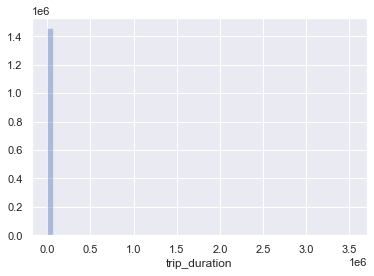

In [75]:
sns.distplot(train_data['trip_duration'], kde=False)

In [76]:
train_data['trip_duration'].quantile([0.25,0.5,0.75,0.99, 1])

0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

As we can see, this training data contains outliers

<AxesSubplot:xlabel='trip_duration'>

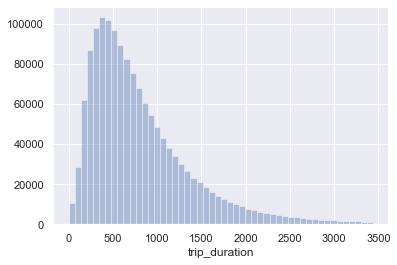

In [77]:
sns.distplot(train_data.trip_duration[train_data['trip_duration'] < 3440], kde=False)

In the competition, the quality metric was RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

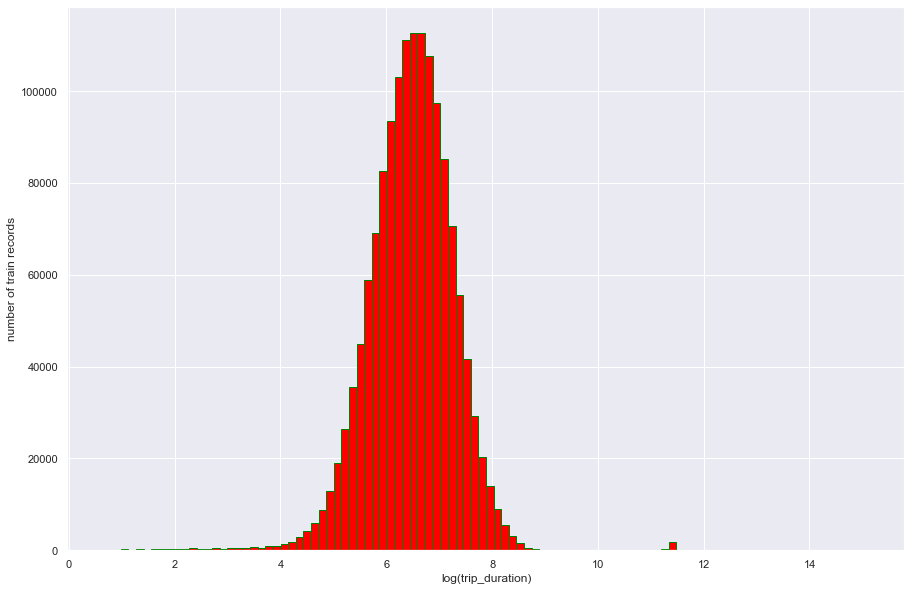

CPU times: user 246 ms, sys: 41.5 ms, total: 287 ms
Wall time: 132 ms


In [78]:
%%time
plt.figure(figsize=(15,10))
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'].values)
plt.hist(train_data['log_trip_duration'].values, bins=100,color="red",edgecolor="green",align="mid")
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [79]:
# longest trip in hours
train_data['trip_duration'].max() // 3600 

979

let's see how mtrips there were on each of the days. Build a graph of the dependence of the number of trips on the day of the year

In [80]:
from datetime import datetime
train_data['dow'] = train_data.pickup_datetime.dt.dayofweek
train_data['month'] = train_data.pickup_datetime.dt.month
train_data['hour'] = train_data.pickup_datetime.dt.hour
train_data['doy'] = train_data.pickup_datetime.dt.dayofyear

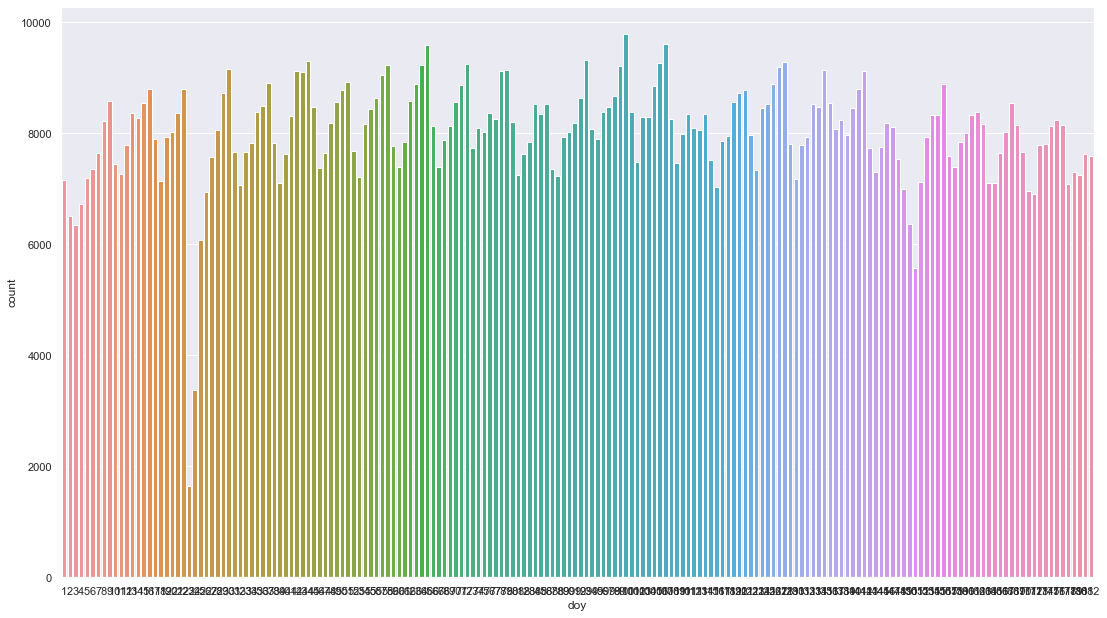

In [81]:
fig, ax = plt.subplots()
ax = sns.countplot(data=train_data, x='doy')
fig.set_size_inches(18.5, 10.5)

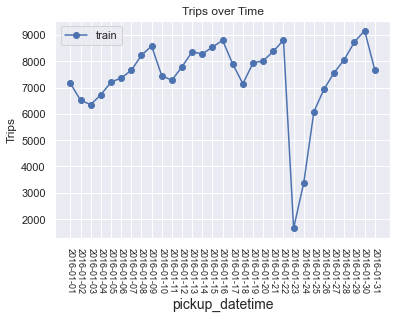

In [82]:
train_data['day']=train_data['pickup_datetime'].dt.date.astype(str)
day_count = train_data.loc[train_data.day.str.contains('2016-01')].groupby('day').count()[['id']]
plt.plot(day_count, 'o-', label='train')
plt.title('Trips over Time')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.xlabel('pickup_datetime',fontsize=14)
plt.xticks(rotation=270, fontsize=9)
plt.show()
         

In [83]:
grouped = train_data.groupby(by='doy').agg({'id':'count'}).reset_index()

In [84]:
! pip install plotly

In [85]:
import plotly.express as px
px.line(grouped, x='doy', y='id')
train_data[(train_data.doy >22) & (train_data.doy < 25)]
train_data['anomaly'] = train_data.doy.between(23, 24).apply(int)

In [86]:
sum(train_data.anomaly)

5031

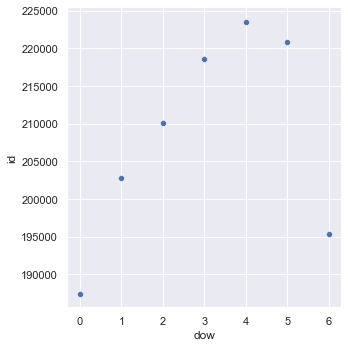

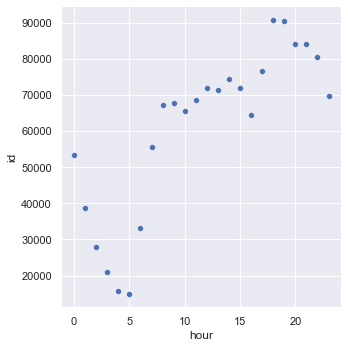

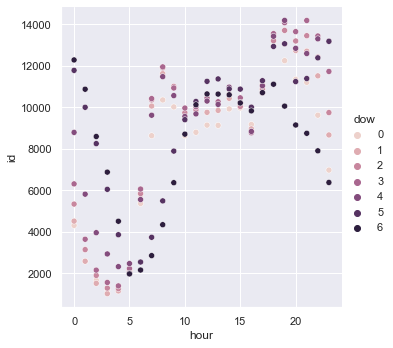

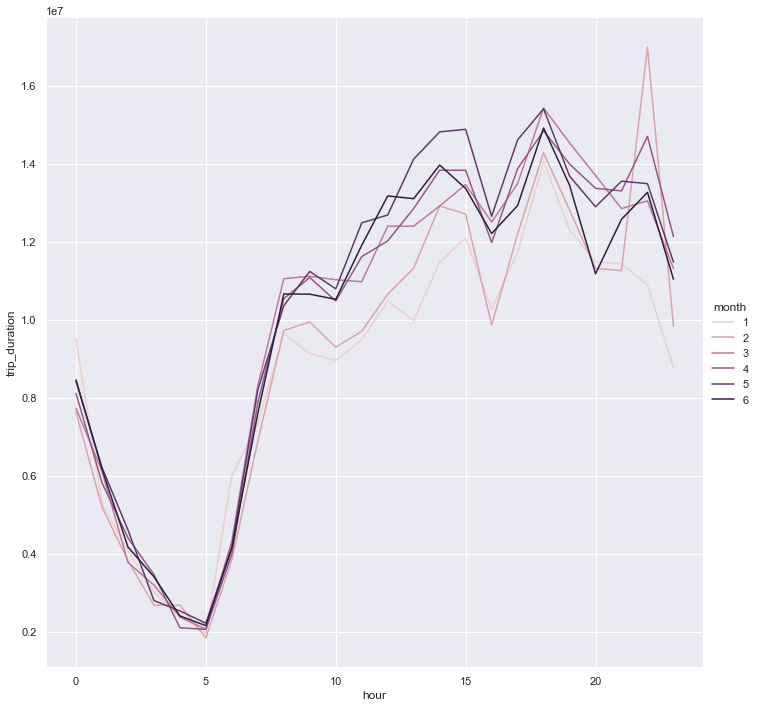

In [87]:
grouped = train_data.groupby(by='dow').agg({'id':'count'}).reset_index()
sns.relplot(data=grouped, x='dow', y='id')
px.line(grouped, x='dow', y='id')
grouped = train_data.groupby(by=['hour']).agg({'id':'count'}).reset_index()
sns.relplot(data=grouped, x='hour', y='id')
px.line(grouped, x='hour', y='id')
grouped = train_data.groupby(by=['dow', 'hour']).agg({'id':'count'}).reset_index()
sns.relplot(data=grouped, x='hour', y='id', hue='dow')
px.line(grouped, x='hour', y='id', color='dow')
data1 = pd.DataFrame({'hour': train_data.hour, 'month': train_data.month, 'trip_duration': train_data['trip_duration']}).groupby([ 'hour', 'month']).sum().reset_index()
sns.relplot(data=data1, x='hour', y='trip_duration', hue="month", kind="line", height=10)

Using the training sample, draw a graph of the average logarithm of travel time versus the day of the week. Then do the same, but for an hour in a day and a day in a year. 

In [88]:
from sklearn.model_selection import train_test_split
not_use_cols = ['id', 'vendor_id', '']
use_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
           'store_and_fwd_flag', 'dow', 'doy', 'hour', 'month', 'anomaly', 'trip_duration', 'log_dur']

In [89]:
train_data['log_dur'] = np.log(train_data.trip_duration + 1)
train, test = train_test_split(train_data[use_cols], test_size=0.3)

In [90]:
grouped = train.groupby(by='dow').agg({'log_dur':'mean'}).reset_index()
px.line(grouped, x='dow', y='log_dur')

In [91]:
grouped = train.groupby(by='hour').agg({'log_dur':'mean'}).reset_index()
px.line(grouped, x='hour', y='log_dur')

In [92]:
grouped = train.groupby(by='doy').agg({'log_dur':'mean'}).reset_index()
px.line(grouped, x='doy', y='log_dur')

Add the following tags based on pickup_datetime:

Day of the week
Month
Hour
Is the period anomalous (two binary signs corresponding to two anomalous periods)
Number of the day of the year

In [93]:
df = pd.DataFrame()
df['dayofweek'] = train_data['pickup_datetime'].apply(lambda x: x.dayofweek)
df['month'] = train_data['pickup_datetime'].apply(lambda x: x.month)
df['hour'] = train_data['pickup_datetime'].apply(lambda x: x.hour)
df['dayofyear'] = train_data['pickup_datetime'].apply(lambda x: x.dayofyear)
df['isabnormal'] = 0

In [94]:
type(df.month[1])

numpy.int64

In [95]:
anomaly = [23, 24, 25, 150, 151]
df.loc[df['dayofyear'].isin(anomaly), 'isabnormal'] = 1

In [96]:
df.head()

dayofweek  month  hour  dayofyear  isabnormal
0          0      3    17         74           0
1          6      6     0        164           0
2          1      1    11         19           0
3          2      4    19         97           0
4          5      3    13         86           0

Train Ridge regression with default parameters by encoding all categorical features with OneHotEncoder. Scale numerical features using the StandardScaler

In [97]:
from sklearn.preprocessing import StandardScaler
d = pd.get_dummies(df['dayofweek'], prefix='day')
m = pd.get_dummies(df['month'], prefix='month')
h = pd.get_dummies(df['hour'], prefix='h')
ab = pd.get_dummies(df['isabnormal'], prefix='abnorm')

df = pd.concat([d, df, m, h, ab], axis=1)
df.drop(columns=['dayofweek','month', 'hour', 'isabnormal'], inplace=True)


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['dayofyear']]),columns=['dayofyear'])
df = pd.concat([df, df_scaled], axis=1)
df.drop(columns=['dayofyear'], inplace=True)

In [98]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error 
y = train_data.log_dur
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
np.sqrt(mean_squared_log_error(y_test, y_pred))

0.112174816846038

In [99]:
ridge.score(X_train, y_train)

0.017148081776963697

We have already studied the data about the start time of the trip very well, let's now look at the information about the coordinates of the start and end of the trip. Now, we prepare a function that draws the starting or ending point of the trip on the map.

In [100]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [101]:
show_circles_on_map(train_data.sample(5000), "pickup_latitude", "pickup_longitude", "blue")

In [102]:
show_circles_on_map(test_data.sample(5000), "dropoff_latitude", "dropoff_longitude", "red")

As we all remember perfectly ,  𝑡=𝑠/𝑣ср  (the time is the distance divide by the speed),therefore, it is obvious that the strongest indication will be the distance to be traveled. We cannot calculate the exact distance that a taxi needs to travel, but we can estimate it by calculating the shortest distance between the points of the beginning and the end of the trip. To correctly calculate the distance between two points on Earth, you can use the haversine function.

In [103]:
#!pip install haversine

In [104]:
from haversine import haversine


In [105]:
%%time
train_data['haversine'] = train_data.apply(lambda x: haversine((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)

CPU times: user 13.4 s, sys: 414 ms, total: 13.8 s
Wall time: 13.9 s


In [106]:
train_data['log_haversine'] =  train_data['haversine'].apply(lambda x: np.log(x + 1e-18))

In [107]:
print("Corr haversine: %f , corr log_haversine: %f" % (y.corr(train_data['haversine']), np.log(y).corr(train_data['log_haversine'])))

Corr haversine: 0.573595 , corr log_haversine: 0.382841


Calculate the average speed for each object in the training set by dividing haversine by trip_duration and plot its distribution


(array([1.458631e+06, 3.000000e+00, 2.000000e+00, 4.000000e+00,
        1.000000e+00, 1.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  0.        ,  18.58812538,  37.17625076,  55.76437614,
         74.35250152,  92.94062691, 111.52875229, 130.11687767,
        148.70500305, 167.29312843, 185.88125381]),
 <BarContainer object of 10 artists>)

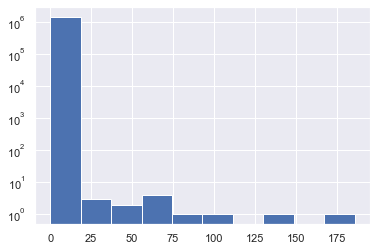

In [108]:
plt.hist(np.array(train_data['haversine']) / np.array(y), log=True)

(array([174803., 483207., 301205., 159297.,  93278.,  59587.,  38367.,
         29256.,  28733.,  17978.]),
 array([0.        , 0.14884362, 0.29768725, 0.44653087, 0.5953745 ,
        0.74421812, 0.89306174, 1.04190537, 1.19074899, 1.33959262,
        1.48843624]),
 <BarContainer object of 10 artists>)

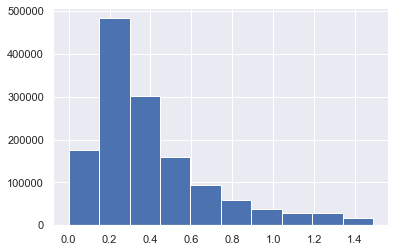

In [109]:
speed = np.array(train_data['haversine']) / np.array(y)
border = np.percentile(speed, 95)
normal_speed = speed[speed < border] 

plt.hist(normal_speed)

Median speed per day per week

In [110]:
def heatmap(X_):
    dw = pd.concat([X_['dayofweek'], X_['hour']], axis=1)
    dw['speed'] = pd.Series(speed)
    
    df = dw.pivot_table(index='dayofweek', columns='hour', values='speed', aggfunc=np.median)
    sns.heatmap(df, annot=False, fmt=".1f")

    plt.show()

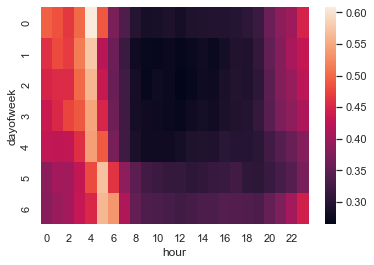

In [111]:
train_data['dayofweek'] = train_data['pickup_datetime'].apply(lambda x: x.dayofweek)
train_data['hour'] = train_data['pickup_datetime'].apply(lambda x: x.hour)

heatmap(train_data)

Create the signs "the trip is made during the traffic jams" and "the trip is made during the free roads" (of course, they should not depend on the speed!):

In [112]:
dw = pd.concat([train_data['dayofweek'], train_data['hour']], axis=1)
dw['speed'] = pd.Series(speed)
df = dw.pivot_table(index='dayofweek', columns='hour', values='speed', aggfunc=np.median)

In [113]:
trafficgam = df <= 0.4

train_data['is_traficgam'] = train_data.apply(lambda x: 1 if trafficgam[ [int(x['hour'])][0]][int(x['dayofweek'])] else 0, axis=1)
train_data['is_not_traficgam'] = train_data['is_traficgam'].apply(lambda x: (x + 1) % 2)


As noted above, two points are highlighted on the map far from Manhattan. For each of them, add two features to the sample: whether the trip began in it and whether it ended in it.

In [114]:
train_data['start'] = train_data['pickup_longitude'].apply(lambda x: 1 if x < -120  else 0)
train_data['end'] = train_data['dropoff_longitude'].apply(lambda x: 1 if x < -120  else 0)

<AxesSubplot:xlabel='is_traficgam', ylabel='log_dur'>

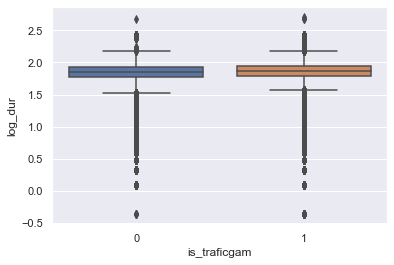

In [115]:
col = ['is_traficgam', 'is_not_traficgam', 'start', 'end']

sns.boxplot(x=train_data[col[0]], y=np.log(y))

<AxesSubplot:xlabel='is_not_traficgam', ylabel='log_dur'>

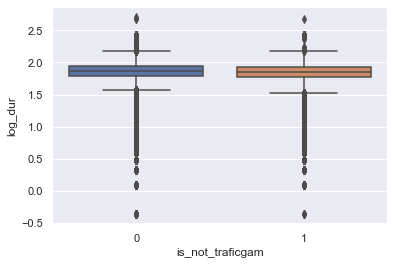

In [116]:
sns.boxplot(x=train_data[col[1]], y=np.log(y))

Now we almost never use the coordinates themselves. There are several reasons for this: separately considering latitude and longitude does not make much sense, it is worth considering them together. Secondly, it is clear that the relationship between our target and coordinates is not linear. To somehow use the coordinates, you can resort to the following trick: frame the area with the most trips with a rectangle (as in the picture). Let's break this rectangle into cells. To each point we associate the number of its cell, and to those points that did not fall into any of the cells, we associate the value -1.

Write a transformer that first breaks the area shown in the figure into cells, and then creates two features: the cell number in which the trip began and the cell number in which the trip ended.

In [117]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,loc, col, row):
        self.location_mh = loc
        self.col = col
        self.row = row

    def create_box_(self, loc):
        polygon_loc = [
                    [(loc[0] - self.walls[0] / 2), loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] + self.walls[1] / 2],
                    [loc[0] - self.walls[0] / 2, loc[1] + self.walls[1] / 2]
                  ]
        return polygon_loc

    def show_map(self):
        self.walls, self.circles_loc = self._fit()
        _map = Map(center=((self.location_mh[:, 0]).mean(), (self.location_mh[:, 1]).mean()),
                   zoom=11, basemap=basemaps.Esri.NatGeoWorldMap)

        circles = [(CircleMarker(location=(lat, long), fill_color='red',
                                 fill_opacity=1, radius=5, stroke=False)) for lat, long in self.circles_loc]
        polygons = [(Polygon(locations=self.create_box_(loc), fill_opacity=0)) for loc in self.circles_loc]

        circles_layer = LayerGroup(layers=circles)
        polygon_layer = LayerGroup(layers=polygons)

        _map.add_layer(circles_layer)
        _map.add_layer(polygon_layer)

        return _map

    def _fit(self):
        self.walls = [(self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col, \
              (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row]

        self.circles_loc = np.array([(((self.location_mh[:, 0].min() + i * (self.walls[0] / 2))), \
                               (self.location_mh[:, 1].min() + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])

        return self.walls, self.circles_loc


    def _transform(self, X):
        _, self.circles_loc = self._fit()
        circles_dict = {ind:loc for ind, loc in enumerate(self.circles_loc)}
        X['start_circle'] = ((X['pickup_latitude'] > self.circles_loc[:, 0].min()) & (X['pickup_latitude'] < self.circles_loc[:, 0].max()) & \
                             (X['pickup_longitude'] > self.circles_loc[:, 1].min()) & (X['pickup_longitude'] < self.circles_loc[:, 1].max())).map({True: 0, False : -1})
        X['end_circle'] = ((X['dropoff_latitude'] > self.circles_loc[:, 0].min()) & (X['dropoff_latitude'] < self.circles_loc[:, 0].max()) & \
                     (X['dropoff_longitude'] > self.circles_loc[:, 1].min()) & (X['dropoff_longitude'] < self.circles_loc[:, 1].max())).map({True: 0, False : -1})
        for index in X.index:
            row = X.loc[index, ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude']]
            for key, value in circles_dict.items():
                box = np.array(self.create_box_(value))
                if ((box[:, 0].min() < row[0]) & (row[0] < box[:, 0].max())) & \
                    ((box[:, 1].min() < row[1]) & (row[1] < box[:, 1].max())):
                    X.loc[index, 'start_circle'] = key
                if ((box[:, 0].min() < row[2]) & (row[2] < box[:, 0].max())) & \
                    ((box[:, 1].min() < row[3]) & (row[3] < box[:, 1].max())): 
                    X.loc[index, 'end_circle'] = key

        return X

Build "boxes with whiskers" of distributions of the logarithm of the trip time depending on the values of each of the features

<AxesSubplot:xlabel='vendor_id', ylabel='log_dur'>

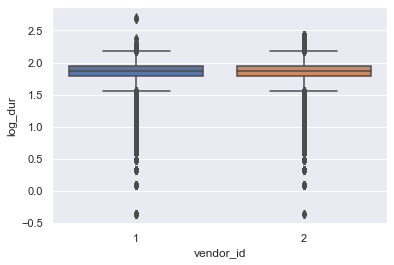

In [118]:
sns.boxplot(x=train_data['vendor_id'], y=np.log(y))

<AxesSubplot:xlabel='passenger_count', ylabel='log_dur'>

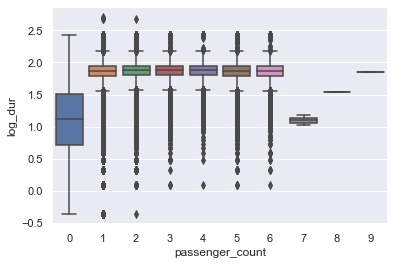

In [119]:
sns.boxplot(x=train_data['passenger_count'], y=np.log(y))

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_dur'>

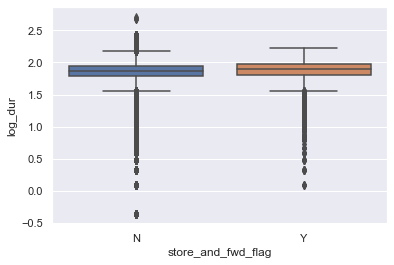

In [120]:
sns.boxplot(x=train_data['store_and_fwd_flag'], y=np.log(y))

In [121]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: x - 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

train_data.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          1 2016-03-14 17:24:55                1   
1  id2377394          0 2016-06-12 00:43:35                1   
2  id3858529          1 2016-01-19 11:35:24                1   
3  id3504673          1 2016-04-06 19:32:31                1   
4  id2181028          1 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

   store_and_fwd_flag  trip_duration  ...         day  anomaly   log_dur  \
0                   0            455  ...  2016-03-14        0  6.122493   
1                   0            663  ...  2016-06-12        0  6.498282   
2                   0           2124  ...  2016-01-19        0  7.661527   
3                   0            429  ...  2016-04-06        0  6.063785   
4                   0            435  ...  2016-03-26        0  6.077642   

   haversine  log_haversine dayofweek  is_traficgam  is_not_traficgam  start  \
0   1.498523       0.404480         0             1                 0      0   
1   1.805510       0.590843         6             1                 0      0   
2   6.385107       1.853968         1             1                 0      0   
3   1.485500       0.395752         2             1                 0      0   
4   1.188590       0.172768         5             1                 0      0   

   end  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 25 columns]

Our hypothesis was tested by training the model on these three features. Ridge regression was trained with standard parameters. Encode the classification features with a single encoding and scale the numerical features.


In [122]:
fl = pd.get_dummies(train_data['store_and_fwd_flag'], prefix='flag')
v_id = pd.get_dummies(train_data['vendor_id'], prefix='v_id')
count = pd.get_dummies(train_data['passenger_count'], prefix='pas_count')

feat = pd.concat([fl, v_id, count], axis=1)

In [123]:
train_data.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          1 2016-03-14 17:24:55                1   
1  id2377394          0 2016-06-12 00:43:35                1   
2  id3858529          1 2016-01-19 11:35:24                1   
3  id3504673          1 2016-04-06 19:32:31                1   
4  id2181028          1 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

   store_and_fwd_flag  trip_duration  ...         day  anomaly   log_dur  \
0                   0            455  ...  2016-03-14        0  6.122493   
1                   0            663  ...  2016-06-12        0  6.498282   
2                   0           2124  ...  2016-01-19        0  7.661527   
3                   0            429  ...  2016-04-06        0  6.063785   
4                   0            435  ...  2016-03-26        0  6.077642   

   haversine  log_haversine dayofweek  is_traficgam  is_not_traficgam  start  \
0   1.498523       0.404480         0             1                 0      0   
1   1.805510       0.590843         6             1                 0      0   
2   6.385107       1.853968         1             1                 0      0   
3   1.485500       0.395752         2             1                 0      0   
4   1.188590       0.172768         5             1                 0      0   

   end  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 25 columns]